Code used for the paper: "Inverse design of viral infectivity enhancing peptides fibrils from continuous protein-vector embeddings" by
K. Kaygisiz, A. Dutta, L. Rauch-Wirth, C. V. Synatschke, J. Münch, T. Bereau, and T. Weil 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pickle
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore') 
plt.style.use('ggplot')

date = datetime.datetime.now().strftime('%Y-%m-%d')
print(f'Last compiled on {date}.')

Last compiled on 2023-03-06.


### Import experimental data. 
- As mentioned in the current paper, we reported this experimental data in another paper: "Data-Mining Unveils Structure-Property-Activity Correlation of Viral Infectivity Enhancing Self-Assembling Peptides" by K. Kaygisiz, L. Rauch-Wirth, A. Dutta, X. Yu, Y. Nagata, T. Bereau, J. Münch, C. V. Synatschke, T. Weil. Preprint available at https://doi.org/10.26434/chemrxiv-2023-hfqxb


In [2]:
exptData_and_descriptors = pd.read_csv(
    '../data/formatted/exptData_and_descriptors.csv')
exptData_and_descriptors.head()

sequence  log10rel_infectivity        tht       zeta  hydrophobicity  \
0    CKIKIQIII             -0.010452   4.140474  15.100000        0.926667   
1      CEIEIQI             -1.554193   2.230026 -27.033333        0.777143   
2    CKIKQIINM             -0.303517  14.669886  12.400000        0.596667   
3  CKFKFQFNMWQ              0.064460   2.426690  17.033333        0.670000   
4    CKFKFQFNM              0.094167   2.382792  15.133333        0.593333   

   length        pI    charge          mw  instaIndex  ...     boman  \
0       9  9.676251  1.866424  1071.42994  -19.411111  ... -1.026667   
1       7  3.613688 -2.131778   846.99394  126.371429  ...  0.445714   
2       9  9.676251  1.866424  1090.40754   16.333333  ...  0.543333   
3      11  9.676251  1.866424  1506.80304  -11.427273  ...  1.265455   
4       9  9.676251  1.866424  1192.45914  -16.188889  ...  1.190000   

   aliphaticIndex  graphShape   upsilon  smoothedUpsilon  polarizability  \
0      216.666667    3.117778  0.862222         0.858889        0.186222   
1      167.142857    2.717143  0.817143         0.812857        0.166857   
2      130.000000    2.625556  0.806667         0.795556        0.184333   
3        0.000000    1.949091  0.634545         1.079091        0.195545   
4        0.000000    2.208889  0.700000         0.712222        0.219000   

   normVdWVol  locElecEff   hDonors  nonBondingOrb  
0    3.991111    0.013333  0.666667       0.555556  
1    3.705714    0.040000  0.571429       1.571429  
2    3.922222    0.026667  0.888889       0.888889  
3    4.083636    0.037273  0.909091       1.000000  
4    4.552222    0.040000  0.888889       0.888889  

[5 rows x 21 columns]

### Calculate protVecs for the peptides

In [3]:
threeGrams = pd.read_csv('../data/raw/dataverse_files/protVec_100d_3grams.csv',
                         sep='\t')
# threeGrams

seqs = exptData_and_descriptors.sequence.to_list()
# len(seqs)
# print(seqs)
seq_vecs = np.zeros((len(seqs), 100))
trips = []
for j, s in enumerate(seqs):
    seq_vec = np.zeros(100)
    #     print(j,s)
    for i in range(len(s) - 2):
        trip = s[i] + s[i + 1] + s[i + 2]
        trips.append(trip)
        seq_vec = seq_vec + \
            np.array(threeGrams.loc[threeGrams['words'] == trip].T[1:]).T[0]
    seq_vecs[j][:] = seq_vec
#     break
# print("ProtVec import:", seq_vecs.shape)

full_data_and_descriptors = pd.concat(
    [exptData_and_descriptors,
     pd.DataFrame(seq_vecs)], axis=1)

# Rename the columns (like 0->vec0)
def conv(x):
    if (isinstance(x, str) != True):
        return 'vec' + str(int(x) + 1)
    else:
        return x

full_data_and_descriptors.columns = full_data_and_descriptors.columns.map(
    lambda x: conv(x))

full_data_and_descriptors.head()


sequence  log10rel_infectivity        tht       zeta  hydrophobicity  \
0    CKIKIQIII             -0.010452   4.140474  15.100000        0.926667   
1      CEIEIQI             -1.554193   2.230026 -27.033333        0.777143   
2    CKIKQIINM             -0.303517  14.669886  12.400000        0.596667   
3  CKFKFQFNMWQ              0.064460   2.426690  17.033333        0.670000   
4    CKFKFQFNM              0.094167   2.382792  15.133333        0.593333   

   length        pI    charge          mw  instaIndex  ...     vec91  \
0       9  9.676251  1.866424  1071.42994  -19.411111  ... -0.718925   
1       7  3.613688 -2.131778   846.99394  126.371429  ... -0.314386   
2       9  9.676251  1.866424  1090.40754   16.333333  ... -0.394551   
3      11  9.676251  1.866424  1506.80304  -11.427273  ... -0.897822   
4       9  9.676251  1.866424  1192.45914  -16.188889  ... -0.505316   

      vec92     vec93     vec94     vec95     vec96     vec97     vec98  \
0  0.324431 -0.017477 -0.647650  0.310433 -0.672134 -0.048616 -0.062050   
1  0.126080  0.431232 -0.169365  0.456279 -0.180621  0.440706 -0.014073   
2  0.522031  0.260854 -0.159696  0.365794 -0.196005  0.059878 -0.430295   
3  0.276586 -0.184170 -0.854667  0.662538 -0.225763 -0.035112 -0.842373   
4  0.518738 -0.197855 -0.451166  0.389407 -0.221619 -0.119568 -0.654088   

      vec99    vec100  
0  0.543923  1.053083  
1  0.588782  0.239009  
2  0.434128  1.018311  
3  0.446190  1.466544  
4  0.146434  0.987638  

[5 rows x 121 columns]

In [4]:
# Create a list of names for ProtVec descriptors
protVecs = ['vec' + str(x) for x in range(1, 101)]
# protVecs

In [5]:
# A nice way to display the trained model. Taken From https://github.com/PacktPublishing/Python-Real-World-Machine-Learning/blob/master/Module%202/Chapter%207/ch7.lasso.py
def pretty_print_linear(coefs, names=None, sort=False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key=lambda x: -np.abs(x[0]))
    return " + ".join("(%s) * %s" % (round(coef, 3), name)
                      for coef, name in lst)

## Note: This is the main model used in the Monte Carlo (MC) routine to generate the peptides reported in this paper.

### Learning log(infectivity) from the data protVecs and LASSO. 

In [6]:
Y = full_data_and_descriptors.log10rel_infectivity
X = full_data_and_descriptors.loc[:, protVecs]
names = X.columns.to_list()
# print(names)

lasso_model_protVecs_log10rel_infectivity = LassoCV(alphas=np.arange(
    0.001, 0.1, 0.0001),
                                                    cv=5).fit(X, Y)

print('------------------------\nResults\n------------------------')
print(f'Intercept: {round(lasso_model_protVecs_log10rel_infectivity.intercept_,3)}')
print(
    "Coefficients with variables: ",
    pretty_print_linear(lasso_model_protVecs_log10rel_infectivity.coef_,
                        names,
                        sort=True))
print('------------------------')

print(
    f'Mean squared error = {round(mean_squared_error(Y, lasso_model_protVecs_log10rel_infectivity.predict(X)),3)}'
)
print(
    f'Mean absolute error = {round(mean_absolute_error(Y, lasso_model_protVecs_log10rel_infectivity.predict(X)),3)}'
)

print(
    f'R^2 = {round(r2_score(Y, lasso_model_protVecs_log10rel_infectivity.predict(X)),3)}'
)

print(
    f'Pearson correlation = {Y.corr(pd.Series(lasso_model_protVecs_log10rel_infectivity.predict(X)))}'
)

# Store the predicted log10rel_infectivity values in the dataframe
full_data_and_descriptors[
    'log10rel_infectivity_from_protVecs_lasso'] = lasso_model_protVecs_log10rel_infectivity.predict(
        X)

# # Save the learned model as a pickle file so that it can be used in MC steps
# # NOTE: Uncommenting the next line will rewrite the trained model!
# with open('./monteCarlo/lasso_model_protVecs_log10rel_infectivity.pkl',
#           'wb') as file:
#     pickle.dump(lasso_model_protVecs_log10rel_infectivity, file)

# # to have a look at the coefficients
# len(lasso_model_protVecs_log10rel_infectivity.coef_)
# for i in range(100):
#     print(i+1,round(lasso_model_protVecs_log10rel_infectivity.coef_[i],3))

# # A cross-check that saving the model as a pickle file works. It does.
# with open('./monteCarlo/lasso_model_protVecs_log10rel_infectivity.pkl',
#           'rb') as file:
#     test = pickle.load(file)
# test.predict(X)[:10]
# lasso_model_protVecs_log10rel_infectivity.predict(X)[:10]
# foo = []
# for i in range(10):
#     foo.append(np.dot(lasso_model_protVecs_log10rel_infectivity.coef_,X.iloc[i,:]) + lasso_model_protVecs_log10rel_infectivity.intercept_)
# np.array(foo)

------------------------
Results
------------------------
Intercept: -2.004
Coefficients with variables:  (-0.496) * vec40 + (-0.467) * vec4 + (-0.374) * vec30 + (-0.276) * vec68 + (-0.239) * vec8 + (-0.212) * vec20 + (0.179) * vec55 + (-0.17) * vec88 + (0.153) * vec16 + (0.131) * vec59 + (0.129) * vec57 + (0.099) * vec100 + (-0.095) * vec43 + (0.06) * vec22 + (0.057) * vec46 + (-0.05) * vec99 + (-0.03) * vec71 + (0.024) * vec60 + (-0.009) * vec61 + (-0.009) * vec54 + (-0.002) * vec52 + (0.0) * vec1 + (0.0) * vec2 + (-0.0) * vec3 + (-0.0) * vec5 + (-0.0) * vec6 + (-0.0) * vec7 + (-0.0) * vec9 + (0.0) * vec10 + (0.0) * vec11 + (-0.0) * vec12 + (-0.0) * vec13 + (0.0) * vec14 + (0.0) * vec15 + (-0.0) * vec17 + (0.0) * vec18 + (-0.0) * vec19 + (-0.0) * vec21 + (-0.0) * vec23 + (-0.0) * vec24 + (0.0) * vec25 + (-0.0) * vec26 + (0.0) * vec27 + (-0.0) * vec28 + (0.0) * vec29 + (-0.0) * vec31 + (-0.0) * vec32 + (0.0) * vec33 + (-0.0) * vec34 + (-0.0) * vec35 + (0.0) * vec36 + (-0.0) * vec37 + 

### Learning log(infectivity) from protVecs and RIDGE regression. 

- We *didn't use* this model for making any predictions or to generate new peptides via Monte Carlo (we used the LASSO model since it is a simpler model with fewer parameters). In the supplementary information of the paper, we provided a comparison between the used LASSO model and the following RIDGE model.

In [7]:
Y = full_data_and_descriptors.log10rel_infectivity
X = full_data_and_descriptors.loc[:, protVecs]
names = X.columns.to_list()
# print(names)

ridge_model_protVecs_log10rel_infectivity = RidgeCV(alphas=np.arange(
    25, 30, .01),
                                                    cv=5).fit(X, Y)

print('------------------------\nResults\n------------------------')
print(f'Intercept: {round(ridge_model_protVecs_log10rel_infectivity.intercept_,3)}')
print(
    "Coefficients with variables: ",
    pretty_print_linear(ridge_model_protVecs_log10rel_infectivity.coef_,
                        names,
                        sort=True))
print('------------------------')

print(
    f'Mean squared error = {round(mean_squared_error(Y, ridge_model_protVecs_log10rel_infectivity.predict(X)),3)}'
)
print(
    f'Mean absolute error = {round(mean_absolute_error(Y, ridge_model_protVecs_log10rel_infectivity.predict(X)),3)}'
)

print(
    f'R^2 = {round(r2_score(Y, ridge_model_protVecs_log10rel_infectivity.predict(X)),3)}'
)

print(
    f'Pearson correlation = {Y.corr(pd.Series(ridge_model_protVecs_log10rel_infectivity.predict(X)))}'
)

# Store the predicted log10rel_infectivity values in the dataframe
full_data_and_descriptors[
    'log10rel_infectivity_from_protVecs_ridge'] = ridge_model_protVecs_log10rel_infectivity.predict(
        X)

# # Cross-check. They match.
# ridge_model_protVecs_log10rel_infectivity.predict(X)[:10]

# for i in range(10):
#     np.inner(ridge_model_protVecs_log10rel_infectivity.coef_,X.iloc[i,:])+ridge_model_protVecs_log10rel_infectivity.intercept_

------------------------
Results
------------------------
Intercept: -1.826
Coefficients with variables:  (-0.191) * vec40 + (-0.184) * vec4 + (-0.153) * vec30 + (-0.115) * vec68 + (-0.108) * vec8 + (0.106) * vec100 + (-0.099) * vec88 + (-0.095) * vec42 + (-0.09) * vec20 + (0.087) * vec46 + (0.083) * vec22 + (-0.081) * vec35 + (0.079) * vec36 + (-0.074) * vec37 + (-0.072) * vec52 + (-0.071) * vec61 + (0.071) * vec59 + (-0.071) * vec32 + (0.069) * vec33 + (-0.069) * vec54 + (0.069) * vec55 + (-0.069) * vec43 + (0.068) * vec14 + (-0.067) * vec94 + (0.066) * vec60 + (-0.065) * vec39 + (0.064) * vec57 + (0.064) * vec16 + (0.062) * vec87 + (-0.06) * vec62 + (-0.055) * vec72 + (-0.053) * vec47 + (-0.053) * vec38 + (0.053) * vec49 + (-0.052) * vec28 + (-0.052) * vec24 + (-0.05) * vec23 + (0.049) * vec2 + (0.047) * vec65 + (-0.046) * vec9 + (0.045) * vec80 + (-0.042) * vec17 + (-0.042) * vec3 + (-0.042) * vec98 + (-0.041) * vec64 + (-0.04) * vec44 + (0.038) * vec84 + (-0.038) * vec82 + (-0.035

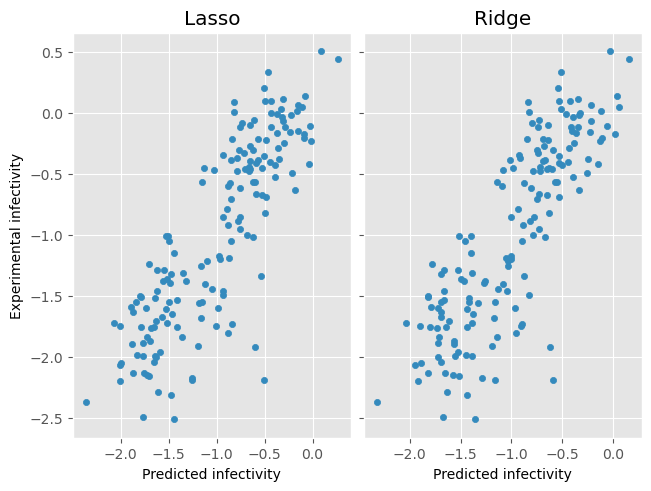

In [8]:
fig, ax = plt.subplots(1,
                       2,
                       sharey=True,
                       constrained_layout=True)

full_data_and_descriptors.plot.scatter(
    'log10rel_infectivity_from_protVecs_lasso',
    'log10rel_infectivity',
    ax=ax[0])
full_data_and_descriptors.plot.scatter(
    'log10rel_infectivity_from_protVecs_ridge',
    'log10rel_infectivity',
    ax=ax[1])
    
ax[0].set_xlabel('Predicted infectivity')
ax[0].set_ylabel('Experimental infectivity')
ax[1].set_xlabel('Predicted infectivity')

ax[0].set_title('Lasso')
ax[1].set_title('Ridge')

pass;

In [9]:
# # Predicting zeta potential from protVecs and LASSO. We *didn't use* this model in our paper. We're keeping the code just for legacy reasons.

# Y = full_data_and_descriptors.zeta
# X = full_data_and_descriptors.loc[:, protVecs]
# names = X.columns.to_list()
# # print(names)

# lasso_model_protVecs_zeta = LassoCV(alphas=np.arange(.01, .1, .001),
#                                     cv=5,
#                                     max_iter=10000).fit(X, Y)

# print('------------------------\nResults\n------------------------')
# print(f'Intercept: {round(lasso_model_protVecs_zeta.intercept_,3)}')
# print("Coefficients with variables: ",
#       pretty_print_linear(lasso_model_protVecs_zeta.coef_, names, sort=True))
# print('------------------------')

# print(
#     f'Mean squared error = {round(mean_squared_error(Y, lasso_model_protVecs_zeta.predict(X)),3)}'
# )
# print(
#     f'Mean absolute error = {round(mean_absolute_error(Y, lasso_model_protVecs_zeta.predict(X)),3)}'
# )

# print(f'R^2 = {round(r2_score(Y, lasso_model_protVecs_zeta.predict(X)),3)}')


# print(
#     f'Pearson correlation = {Y.corr(pd.Series(lasso_model_protVecs_zeta.predict(X)))}'
# )

# # Store the predicted zeta values in the dataframes
# full_data_and_descriptors[
#     'zeta_from_protVecs_lasso'] = lasso_model_protVecs_zeta.predict(X)

# # Save the learned model as a pickle file
# # with open('./monteCarlo/lasso_model_protVecs_zeta.pkl', 'wb') as file:
# #     pickle.dump(lasso_model_protVecs_zeta, file)

# # Cross-check. They match
# with open('./monteCarlo/lasso_model_protVecs_zeta.pkl', 'rb') as file:
#     test = pickle.load(file)
# test.predict(X)[:10] 
# lasso_model_protVecs_zeta.predict(X)[:10]
# for i in range(10):
#     np.inner(lasso_model_protVecs_zeta.coef_,X.iloc[i,:])+lasso_model_protVecs_zeta.intercept_